#Imports

In [ ]:
import sys
import os
import time
import json

import statsmodels.api as sm

import numpy as np
import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import seaborn as sns   

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.manifold import TSNE

from sklearn import tree


prop = [.9, .1]

seed = 42

#Import Data

In [ ]:
# Imports csv file from github
url = 'https://github.com/AaronUpchurch/CAP4770-Project/blob/main/data.csv?raw=true'
countries_x = pd.read_csv(url,index_col=0)

url5 = 'https://raw.githubusercontent.com/AaronUpchurch/CAP4770-Project/main/full_y.csv'
suicide_rates = pd.read_csv(url5, index_col = 0, encoding='cp1252', on_bad_lines = "skip").to_dict()
suicide_rates = suicide_rates["Rate"]

url3 = 'https://raw.githubusercontent.com/AaronUpchurch/CAP4770-Project/main/backup_codes.csv'
country_codes = pd.read_csv(url3, index_col = 0)
country_codes = country_codes['CountryName'].to_dict()


In [ ]:
short_x_col = ['tot_area','land_area','water_arae','bound_land','coast','arg_land_per','for_land_per','tot_dep_rat','youth_dep_rat','eld_dep_rat','med_age','pop_growth_rate','birth_rate','death_rate','net_mig_rate','urb_pop','urban_rate','sex_ratio','mat_mor_rate','inf_mor_rate','life_exp','fert_rate','health_exp','phy_den','edu_exp','part_emi','meth_emi','urb_pop_per','urb_rate','real_gdp','read_gdp_per_cap','gdp','pop_bel_pov']

#Data Cleaning

###Convert country codes to country names

In [ ]:
# Manually add some missing country codes
country_codes["DX"] = 'Dhekelia'
country_codes["JN"] = 'Jan Mayen'
country_codes["KV"] = 'Kosovo'
country_codes['WE'] = 'West Bank'
country_codes['BQ'] = 'Navassa Island'
country_codes['NN'] = 'Sint Maarten'
country_codes['UC'] = 'Curacao'
country_codes['WQ'] = 'Wake Island'
country_codes['IP'] = 'Cipperton Island'

oldNames = list(countries_x.index)
for index, name in enumerate(oldNames):
  if(len(name) ==2):
      oldNames[index] = country_codes[name]

countries_x = countries_x.rename(index=country_codes)



###Combine country dataset with suicide rates

In [ ]:
suicide_list = []
for name in countries_x.index:
  try:
    suicide_list.append(suicide_rates[name])
  except:
    suicide_list.append("")
countries_x['suicide_rate'] = suicide_list

###Remove duplicated countries

In [ ]:
countries_x = countries_x[~countries_x.index.duplicated(keep='first')]

###Remove countries with missing suicide rates

In [ ]:
countries_to_drop = countries_x.loc[countries_x['suicide_rate'] == ''].index
for name in countries_to_drop:
  print("Removing " + name)
countries_x = countries_x.drop(countries_to_drop)
assert len(countries_x.loc[countries_x['suicide_rate'] == ''].index) == 0

Removing Netherlands Antilles
Removing Dhekelia
Removing San Marino
Removing Isle Of Man
Removing Gibraltar
Removing Guernsey
Removing Swaziland
Removing Vatican City
Removing Aland Islands
Removing Jersey
Removing Jan Mayen
Removing Faroe Islands
Removing Kosovo
Removing Iran, Islamic Republic Of
Removing Palestine
Removing Bosnia And Herzegovina
Removing West Bank
Removing Aruba
Removing Sao Tome And Principe
Removing Virgin Islands, U.S.
Removing U.S. Virgin Islands
Removing Cayman Islands
Removing Marshall Islands
Removing Tokelau
Removing Navassa Island
Removing Saint Barthélemy
Removing Saint Martin (French part)
Removing Saint Pierre And Miquelon
Removing Sint Maarten
Removing Puerto Rico
Removing Niue
Removing Curacao
Removing Anguilla
Removing Nauru
Removing Cook Islands
Removing United States Outlying Islands
Removing Wake Island
Removing Antarctica
Removing New Caledonia
Removing French Polynesia
Removing Norfolk Island
Removing Pitcairn
Removing Northern Mariana Islands
Rem

###Remove countries with lots of missing data

In [ ]:
country_names = countries_x.index
missing_to_delete = 4
old_num_countries = countries_x.shape[0]

for name in country_names:
  if (countries_x.loc[name] == -1.0).sum() > missing_to_delete:
    print("Remove " + str(name))
    countries_x = countries_x.drop(name)

print("Removed " + str(old_num_countries - countries_x.shape[0]) + " countries")


Remove Lesotho
Remove El Salvador
Remove Mongolia
Remove Kuwait
Remove Syrian Arab Republic
Remove Yemen
Remove Mauritius
Remove United Arab Emirates
Remove Dominican Republic
Remove Cuba
Remove Antigua and Barbuda
Remove Saint Vincent And Grenadines
Remove Seychelles
Remove Tunisia
Remove Timor-Leste
Remove Austria
Remove Niger
Remove Equatorial Guinea
Remove Libyan Arab Jamahiriya
Remove Somalia
Remove Eritrea
Remove South Sudan
Remove Venezuela
Remove Bangladesh
Removed 24 countries


###Remove features with many missing values

In [ ]:
missing_to_drop = 10
columns_to_drop = countries_x.columns[(countries_x == -1.0).sum() >= missing_to_drop]
for name in columns_to_drop:
  print("Removing " + name)
  countries_x = countries_x.drop(name,axis=1)

Removing elevation_mean_m
Removing contraceptive_prevalence
Removing real_gdp_growth_rate
Removing unemployment_rate


###Use data augmentation to replace any leftover NaN values

In [ ]:
nan_count = (countries_x == -1).sum().sum()
print("Still missing " + str(nan_count) + " values")

missing_collumns = countries_x.columns[(countries_x == -1.0).sum() >= 0]

# Get all missing values
missing_data = []
for index in countries_x.index:
  for col in missing_collumns:
    if (countries_x[col][index] == -1):
      missing_data.append( [index, col])

print(pd.DataFrame(missing_data))

# replace with average value in feature
for country, feature in missing_data:
  countries_x.loc[country,feature] = np.mean(countries_x.loc[:,feature])


      

Still missing 20 values
                           0                              1
0         Russian Federation           particulate_emisions
1         Russian Federation              methane_emissions
2               Turkmenistan                       real_gdp
3               Turkmenistan            real_gdp_per_capita
4                  Macedonia          education_expenditure
5     Bosnia and Herzegovina          education_expenditure
6                 Montenegro          education_expenditure
7               Saudi Arabia          education_expenditure
8               Saudi Arabia  population_below_poverty_line
9                      Qatar  population_below_poverty_line
10                      Iraq          education_expenditure
11                  Barbados  population_below_poverty_line
12               New Zealand  population_below_poverty_line
13                   Vanuatu  population_below_poverty_line
14                     Sudan          education_expenditure
15  Central Afri

###Remove any sucide rate outliers

In [ ]:
for name in countries_x.index:
  if (countries_x.loc[name,'suicide_rate'] > 40):
    print("Remove " + str(name))
    countries_x = countries_x.drop(name)

Remove Guyana


#Data Exploration

###Visualize the suicide rates

Add 3 Character Code

In [ ]:
copy = gapminder
copy.drop(copy.columns.difference(['country','iso_alpha']), 1, inplace=True)

	
copy = pd.Series(copy.iso_alpha.values,index=copy.country).to_dict()

countries_x['iso_alpha'] = np.zeros(133) - 1

country_names = countries_x.index

for name in country_names:
  try:
    countries_x.loc[name,'iso_alpha'] = copy[name]
  except:
    pass

countries_x.loc['Russian Federation','iso_alpha'] = 'RUS'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
import plotly.express as px
import numpy as np

countries_x['suicide_rate'] = pd.to_numeric(countries_x['suicide_rate'])

fig = px.choropleth(countries_x, locations="iso_alpha",
                    color="suicide_rate", 
                    hover_name="suicide_rate", 
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

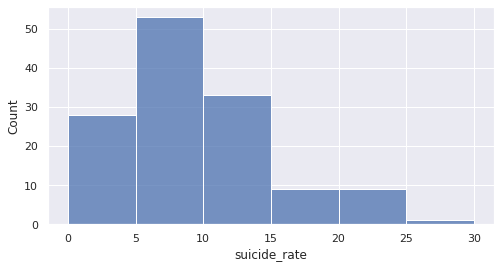

In [ ]:
plt.figure(figsize = (8,4))
sns.histplot(data=countries_x,x='suicide_rate',bins=[0,5,10,15,20,25,30])

###Visualize feature correlation

In [ ]:
countries_x['suicide_rate'] = pd.to_numeric(countries_x['suicide_rate'])

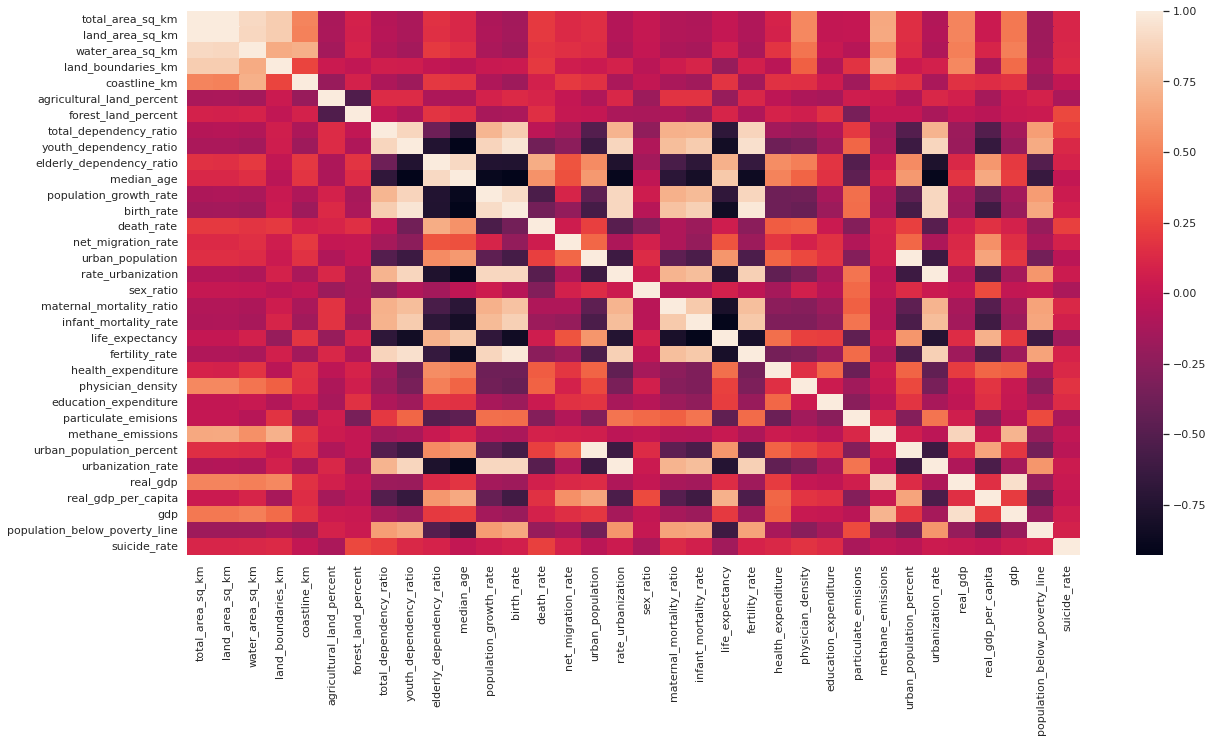

In [ ]:

sns.set(rc = {'figure.figsize':(20,10)})
corrMatrix = countries_x.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

###Which features have the highest correlation with suicide rates?

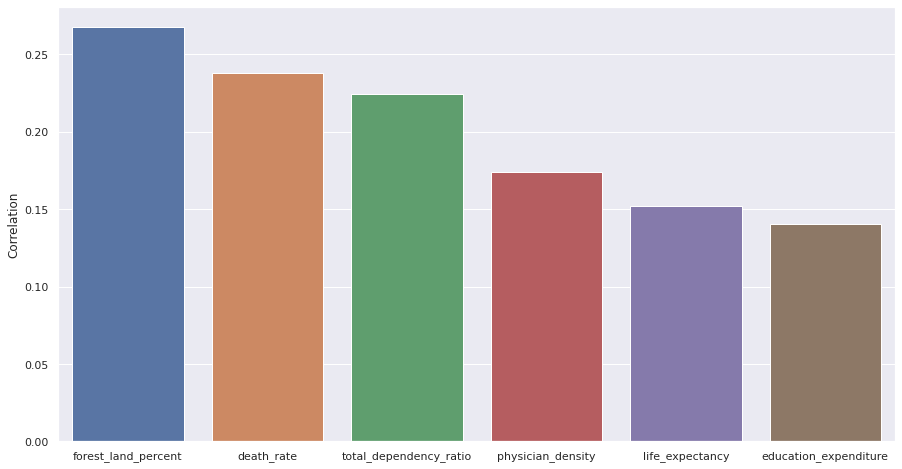

In [ ]:
suicide_corr = corrMatrix['suicide_rate']
suicide_corr = suicide_corr.drop('suicide_rate')
suicide_corr = np.abs(suicide_corr)
suicide_corr = pd.DataFrame(suicide_corr)
suicide_corr.columns = ['Correlation']
suicide_corr = suicide_corr.sort_values('Correlation',ascending=False)
suicide_corr = suicide_corr[0:6]
plt.figure(figsize = (15,8))

sns.barplot(data = suicide_corr, x = suicide_corr.index,y = 'Correlation',order=suicide_corr.sort_values('Correlation',ascending=False).index)

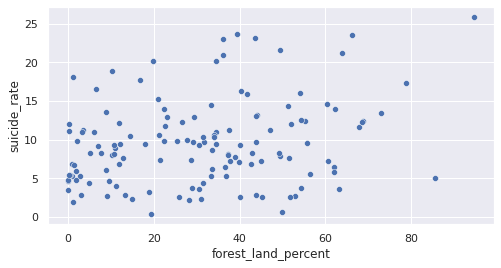

In [ ]:
plt.figure(figsize = (8,4))
sns.scatterplot(data=countries_x,x='forest_land_percent',y='suicide_rate')


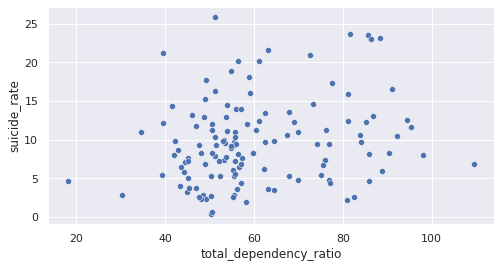

In [ ]:
plt.figure(figsize = (8,4))
sns.scatterplot(data=countries_x,x='total_dependency_ratio',y='suicide_rate')

# Analysis

###Null Hypothesis: There are no significant predictors of suicide rates in countries. Suicide rates are random in nature.

###Alternative Hypothesis: There exists at least one predictor that correlates and can help predict suicide rates within countries.

###Standardize Features

In [ ]:
# Convert to numpy arrays
x_columns = list(countries_x.columns)
x_columns.remove('suicide_rate')
x_columns.remove('iso_alpha')
x_data = countries_x.loc[:,(x_columns)]
y_data = countries_x.loc[:,countries_x.columns == 'suicide_rate']
x_data = np.array(x_data)
y_data = np.array(y_data)



# Standardize data
scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_data)

###Bin Suicide Rates

In [ ]:
y_bins = []
for rate in y_data:
  if rate < 10:
    y_bins.append('low')
  elif rate < 20:
    y_bins.append('medium')
  else:
    y_bins.append('high')

###Spit data into train and test

In [ ]:

train_x, test_x, train_y, test_y = train_test_split(x_data, y_bins, 
                                                    train_size = prop[0], 
                                                    test_size = prop[1],
                                                    random_state = seed)

###Decision Tree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 3,n_estimators=10000)
clf = clf.fit(train_x,train_y)

y_train_pred = clf.predict(train_x)
y_test_pred = clf.predict(test_x)

train_mae = accuracy_score(train_y,y_train_pred)
test_mae = accuracy_score(test_y,y_test_pred)

print("Training Accuracy: " + str(np.round(100*train_mae,2)) + "%")
print("Test Accuracy: " + str(np.round(100*test_mae,2)) + "%")

Training Accuracy: 76.47%
Test Accuracy: 64.29%


###Linear Regression

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, 
                                                    train_size = prop[0], 
                                                    test_size = prop[1],
                                                    random_state = seed)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_x, train_y)

y_train_pred = reg.predict(train_x)
y_test_pred = reg.predict(test_x)

train_mae = mean_absolute_error(train_y,y_train_pred)
test_mae = mean_absolute_error(test_y,y_test_pred)

print("Training MAE: " + str(np.round(train_mae,2)) + "%")
print("Test MAE: " + str(np.round(test_mae,2)) + "%")

Training MAE: 3.3%
Test MAE: 4.81%


F Statistic

In [ ]:
X = countries_x.drop(['suicide_rate','iso_alpha'],1)
y = countries_x['suicide_rate']
X = sm.add_constant(X)

results = sm.OLS(y, X.astype(float)).fit()
A = np.identity(len(results.params))
A = A[1:,:]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           suicide_rate   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     2.095
Date:                Mon, 18 Apr 2022   Prob (F-statistic):            0.00356
Time:                        02:13:45   Log-Likelihood:                -383.32
No. Observations:                 133   AIC:                             826.6
Df Residuals:                     103   BIC:                             913.4
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



([<matplotlib.axis.YTick at 0x7f266b32fad0>,
 <a list of 7 Text major ticklabel objects>)

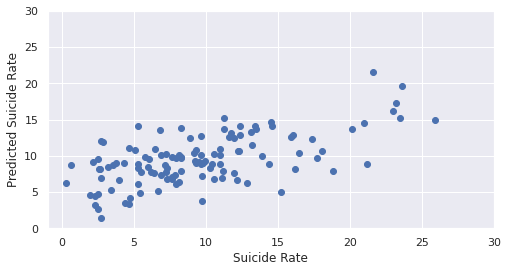

In [ ]:
plt.figure(figsize = (8,4))
p = plt.scatter(x=train_y,y=y_train_pred)
plt.xlabel('Suicide Rate')
plt.ylabel('Predicted Suicide Rate')
plt.xticks([0,5,10,15,20,25,30])
plt.yticks([0,5,10,15,20,25,30])

###Linear Regression with PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

pca_train_x = pca.fit_transform(train_x)
pca_test_x = pca.transform(test_x)

reg = LinearRegression().fit(pca_train_x, train_y)

pca_y_train_pred = reg.predict(pca_train_x)
pca_y_test_pred = reg.predict(pca_test_x)

train_mae = mean_absolute_error(train_y,pca_y_train_pred)
test_mae = mean_absolute_error(test_y,pca_y_test_pred)

print("Training MAE: " + str(np.round(train_mae,2)) + "%")
print("Test MAE: " + str(np.round(test_mae,2)) + "%")



Training MAE: 4.03%
Test MAE: 3.07%


PCA F Test

In [ ]:
X = pca.transform(all_x)
y = countries_x['suicide_rate']
X = sm.add_constant(X)

results = sm.OLS(y, X.astype(float)).fit()
A = np.identity(len(results.params))
A = A[1:,:]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           suicide_rate   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.7736
Date:                Mon, 18 Apr 2022   Prob (F-statistic):              0.654
Time:                        02:13:46   Log-Likelihood:                -410.07
No. Observations:                 133   AIC:                             842.1
Df Residuals:                     122   BIC:                             873.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5528      0.479     19.926      0.0

###Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

poly = PolynomialFeatures(2)
poly_train_x = poly.fit_transform(train_x)
poly_test_x = poly.fit_transform(test_x)

# Only use best features
temp = pd.DataFrame(poly_train_x)

temp['suicide_rate'] = train_y
temp['suicide_rate'] = pd.to_numeric(temp['suicide_rate'])

# Gets best features based on magnitude of weights
def getBestFeatures(features,coefs,n):

    abs_weights = np.absolute(coefs)
    best_coef_index = np.argsort(abs_weights)[-n:]
  
    best_coef_index = np.flip(best_coef_index)[0]

    feat_arr = np.array(features)[best_coef_index]
    en_best_coef = coefs[0,best_coef_index]
    fin = np.ravel((feat_arr,en_best_coef), order = 'F')

    return fin, best_coef_index  

features = countries_x.columns
best_features, best_indexes = getBestFeatures(poly.get_feature_names(features),reg.coef_,2)

new= best_indexes[0:10]

poly_train_x_2 = poly_train_x[:,new]
poly_test_x_2 = poly_test_x[:,new]

reg = LinearRegression().fit(poly_train_x_2, train_y)

y_train_pred = reg.predict(poly_train_x_2)
y_test_pred = reg.predict(poly_test_x_2)

train_mae = mean_absolute_error(train_y,y_train_pred)
test_mae = mean_absolute_error(test_y,y_test_pred)

print("Training MAE: " + str(np.round(train_mae,2)) + "%")
print("Test MAE: " + str(np.round(test_mae,2)) + "%")

Training MAE: 3.88%
Test MAE: 4.14%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



###Clustering

KMeans

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, 
                                                    train_size = prop[0], 
                                                    test_size = prop[1],
                                                    random_state = seed)

88.51302630717805


Text(0, 0.5, 'Inertia')

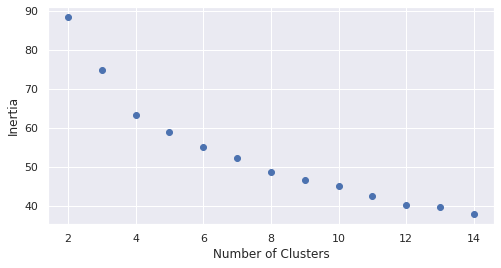

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(train_x)
print(kmeans.inertia_)
ys =[]
for i in range(2,15):
  kmeans = KMeans(n_clusters=i).fit(train_x)
  ys.append(kmeans.inertia_)
x = range(2,15)
plt.figure(figsize = (8,4))
plt.scatter(x,ys)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

In [ ]:
kmeans = KMeans(n_clusters=4).fit(train_x)
all_x = np.concatenate((train_x,test_x))
all_y = np.concatenate((train_y,test_y))
cluster_id = kmeans.predict(all_x)
country_names = np.array(countries_x.index)


Anova Test

In [ ]:
from scipy.stats import f_oneway
cluster_A_suicide = all_y[cluster_id==0][:,0]
cluster_B_suicide = all_y[cluster_id==1][:,0]
cluster_C_suicide = all_y[cluster_id==2][:,0]
cluster_D_suicide = all_y[cluster_id==3][:,0]
F, p = f_oneway(cluster_A_suicide,cluster_B_suicide,cluster_C_suicide,cluster_D_suicide)
print("Anova Test F Statistic: " + str(np.round(F,2)))
print("Anova Test P Value: " + str(np.round(p,2)))

Anova Test F Statistic: 2.39
Anova Test P Value: 0.07


Boxplots

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Text(0, 0.5, 'Suicide Rate')

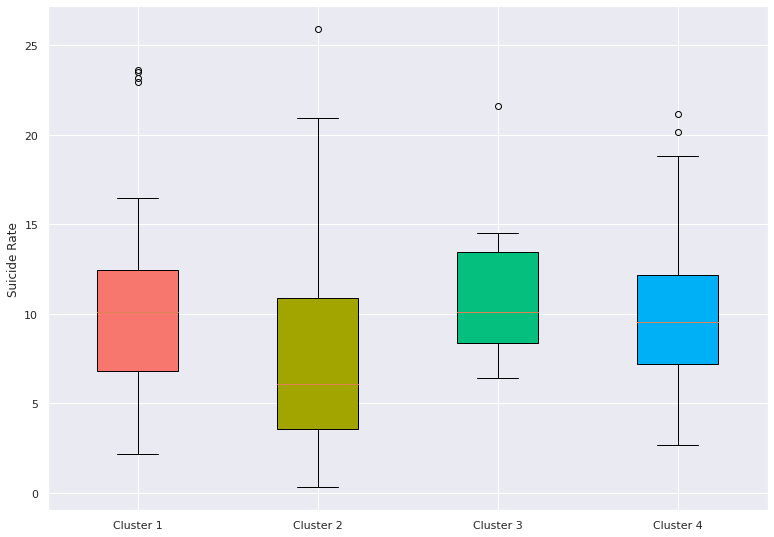

In [ ]:
all_cluster_suicide = [cluster_A_suicide,cluster_B_suicide,cluster_C_suicide,cluster_D_suicide]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(all_cluster_suicide, patch_artist = True)
 
colors = ['#f7766d', '#a2a500',
          '#04bf7e', '#00b0f6']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(['Cluster 1', 'Cluster 2',
                    'Cluster 3', 'Cluster 4'])
ax.set_ylabel('Suicide Rate')

In [ ]:
x_2_dim = TSNE().fit_transform(x_data)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



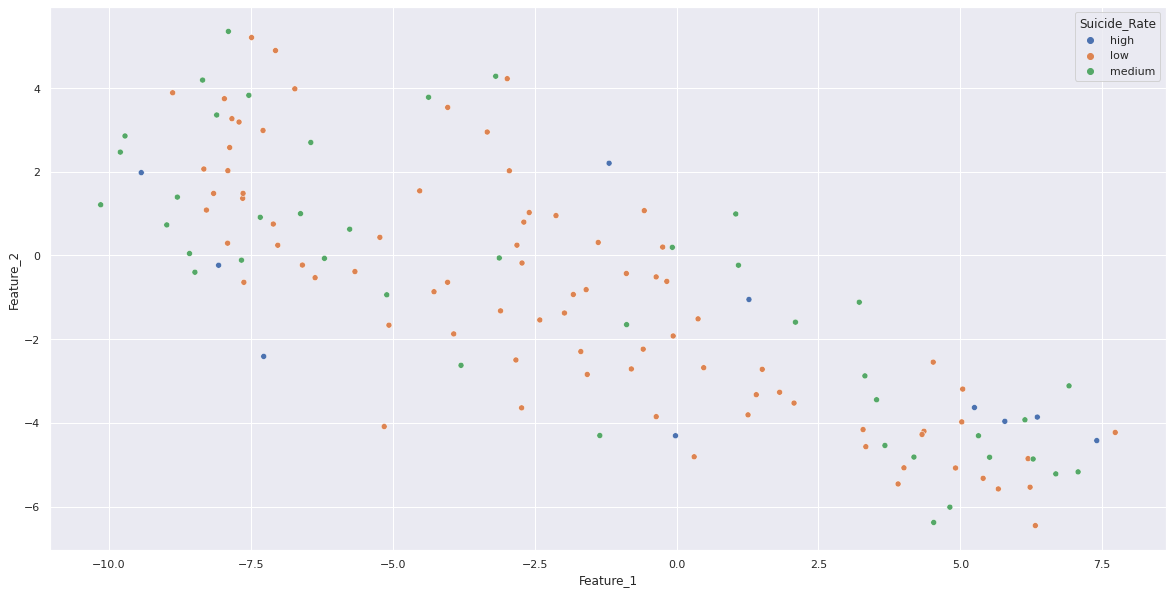

In [ ]:
#plt.figure(figsize = (8,4))
x_2_dim = pd.DataFrame(x_2_dim)
x_2_dim.columns = ['Feature_1','Feature_2']
x_2_dim['Suicide_Rate'] = y_bins
sns.scatterplot(data=x_2_dim,x='Feature_1',y='Feature_2',hue='Suicide_Rate')